## Malignant nodule prediction

To use the knowledge acquired in machine learning, I'll be applying classifiers to predict if a breast nodule is benign or malignant.

At the link: https://archive.ics.edu/ml/datasets/mmographic+Mass you will find the accessed dataset.

But what is a mammogram? Mammography is an imaging technique in medicine that allows for internal structures of the breast as well as appearances of cancer, even lymph nodes, inflamed masses and even breast cancer. A structure that can evolve into a malignant biopsy is precisely a mass, according to the diagnostic definition made. Biopsy rates are approximately $70\%$. The need for a computational model that detects the severity of breast structures is so that there is a reduction in procedures without a real need.

We can build a system that, starting from average goals, we will try to start from several patients, find patterns by supervised learning and reduce this rate. Data used here is fromthe University Erlangen-Nuremberg between 2003 and 2006.

The articles are as follows:

1) BI-RADS Rating: 1 to 5 (ordinal, non-predictive)

2) Age: patient's age (whole)

3) Shape: dough shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4) Margin: mass margin: circumscribed=1 microlobulated=2 obscure=3 ill-defined=4 spike=5 (nominal)

5) Density: mass density: high=1 iso=2 low=3 containing=4 (ordinal fat)

6) Severity: benign=0 or maligni=1 (binominal, target)

There are 961 instances, 6 attributes (4 predictive, 1 target, and 1 non-predictive). The BI-RADS attribute was considered non-predictive, so it will not be included in the models. Severity will be our target.

The following models will be used: Logistic regression, Decision tree and SVM.

## Importing bibs

In [46]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn import (preprocessing,
                     model_selection, metrics, tree, svm)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn import metrics
from sklearn.inspection import permutation_importance
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import missingno as msno
import shap
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

## Pre-processing data

The main data original format was not .csv, however I decided to use this format because it is simpler to handle pandas.

In [7]:
df_mamo = pd.read_csv('../Projects/mamo.csv.data',header= None)

df_mamo.columns = ['BI-RADS', 'Age', 'Shape', 'Margin','Density','Severity']

df_mamo.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


It is noticed that here where there is missing information in the columns, instead of NaN, there are strings of "?". I'll replace with NaNs and then count how many missing values '?' there are for each attribute.

In [8]:
df_mamo.replace('?', np.NaN,inplace=True)

df_mamo.isna().sum()

BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

Despite looking at the amount of missing data, it is interesting to use the missigno library to - in each attribute - observe how much non-missing data we have, and compare in a bar chart.

<AxesSubplot:>

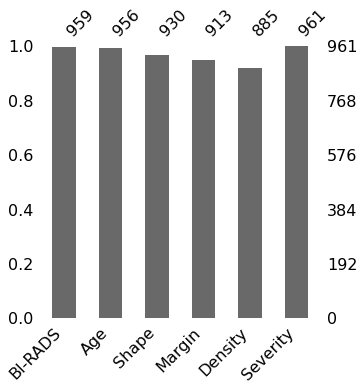

In [10]:
# percentual de dados não ausentes

msno.bar(df_mamo, figsize = (5,5))

Here you can see that compared to the totality, there are not so many missing values. It is necessary to decide, however, what to do with these - because as we will see later, some models do not deal well with missing data. My decision was to replace them with the median of the value because the median can better describe a distribution if there is an outlier, or it is not fully symmetrical.
I also took advantage and deleted the BI-RADS column, as this is a non-predictive feature.

In [11]:
df_mamo.fillna(df_mamo.median().round(1), inplace=True)
df_mamo = df_mamo.astype(int)
df_mamo.drop('BI-RADS', axis=1, inplace=True)

df_mamo.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,3,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,3,1


Normalizing and pre-processing the data is useful to us as they help to improve the performance of some models. In addition, in different units\scales it is also useful to normalize so that there is a standardization of the scales because the procedure we are doing is that the data have the mean 0 and standard deviation equal to 1, and thus a model will not be able to give more importance to a variable with a larger scalar. In this case, the variables do not differ much in scale from each other, only age, but for the sake of possible performance improvement of models that will be mentioned, I will be normalizing the data.

In [12]:
normalizado = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df_mamo[['Age', 'Shape', 'Margin', 'Density']]))
normalizado['Severity'] = df_mamo['Severity']
normalizado.columns = ['Age', 'Shape', 'Margin','Density','Severity']

normalizado.head()

,Age,Shape,Margin,Density,Severity
0,0.796984,0.220384,1.436762,0.224804,1
1,-0.865610,-1.415052,-1.183216,0.224804,1
2,0.173511,1.038102,1.436762,0.224804,1
3,-1.904732,-1.415052,-1.183216,0.224804,0
4,1.281908,-1.415052,1.436762,0.224804,1


## Exploratory analysis

An exploratory data analysis is necessary for us to understand the type of dataset we are dealing with. First, understand if the data are balanced, then understand how they are distributed, if there are outliers and if there is a correlation between the variables. Here we can see the respective averages and deviations of the attributes

In [13]:
df_mamo.describe()

,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,55.495317,2.730489,2.806452,2.917794,0.463059
std,14.442783,1.223552,1.527525,0.365869,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


We can see from describe function our data means have close values such as standard deviation, except for age feature.

The graph below shows that the dataset is well balanced: $53.7 \%$ benign to $46.3\%$ malignant

<AxesSubplot:ylabel='Severity'>

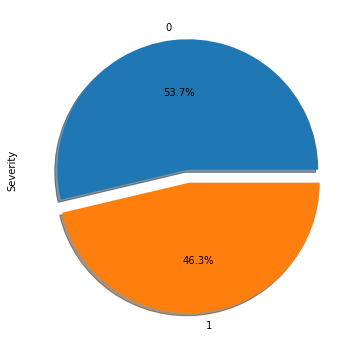

In [14]:
df_mamo['Severity'].value_counts().plot(kind='pie', explode = [0,0.1], figsize = (6,6), autopct = '%1.1f%%', shadow = True)

If the classes were unbalanced, during model training, the most populous classes could bias the classification results. One of the solutions is to use a different metric than the "standard" (accuracy). You can use precision and recall. Another solution would be to use tree-based algorithms, as they can perform better according to the smaller class distribution. What can also be used is a penalty model, as we will see in the sckit-learn functions, as the models accept a parameter called class_weight. By defining this as 'balanced', the model tries to regularize minority classes against the majority.
GridSearch - also used here - searches the model through weight parameters, making it possible to assign higher weights to smaller classes

We can produce a histogram of the attributes to see concentrations of values

C:\Users\Isabelle\AppData\Local\Temp\ipykernel_11720\1137212384.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_mamo.drop(columns = 'Severity').hist(ax = ax)


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Shape'}>],
       [<AxesSubplot:title={'center':'Margin'}>,
        <AxesSubplot:title={'center':'Density'}>]], dtype=object)

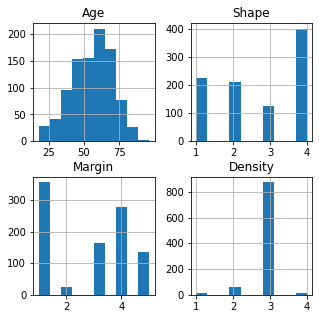

In [16]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
df_mamo.drop(columns = 'Severity').hist(ax = ax)

In the histogram, we can see that for Age, they are well concentrated in middle age. As for shape, the shapes found are mostly of classification 4. In the margin, we see that the values ​​for 1 and 4 are more predominant. In density, it is possible to see that for pattern 3, there is this dominance with respect to the measured values

We can plot the boxplots to check for the presence of outliers. In the case below, we can see that there is no significant presence of these, which is positive because the SVM model is sensitive to outliers.

<AxesSubplot:xlabel='Density'>

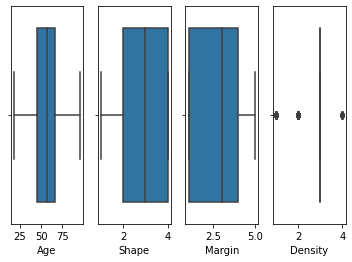

In [17]:
fig, axes = plt.subplots(1, 4)

sns.boxplot(data=df_mamo, x='Age', ax=axes[0])
sns.boxplot(data=df_mamo, x='Shape', ax=axes[1])
sns.boxplot(data=df_mamo, x='Margin', ax=axes[2])
sns.boxplot(data=df_mamo, x='Density', ax=axes[3])

The correlation graph allows us to make pairwise comparisons between attributes. The standard correlation used here was Pearson's, which measures the linear dependence between them, that is, how linearly correlated these variables are with each other. Columns that have a high degree of correlation can impair the interpretation of the importance of coefficients and attributes in the regression. This is due to the fact that logistic regression assumes linear independence between attributes (which will not always correspond to reality, and there are its advantages in using it anyway, an aspect that I will discuss in more depth when I get into the models part) 

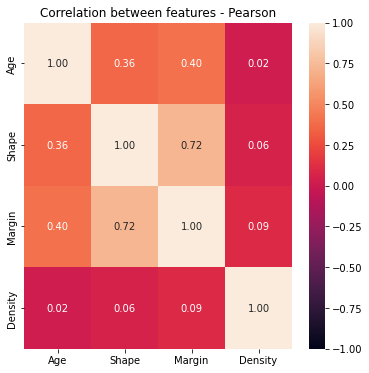

In [18]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Correlation between features - Pearson')
ax = heatmap(df_mamo.drop(columns='Severity').corr(),fmt = '.2f', annot=True, ax=ax, vmin=-1,vmax=1)

Here it can be seen that Shape and Margin are highly correlated, but in general, our attributes are not so strongly correlated. Remembering that 1 is the "perfect" correlation coefficient, that is, fully linearly correlated, having a high degree of correlation if the coefficient is between ± 0.50 and ± 1.
Moderate for values between ±0.30 and ±0.49, and low for values below 0.29

## Modeling 

After analyzing the data, it is necessary to implement the LOGIT, TREE, SVM models. For this, it is necessary to define how the classification models will be made.
This requires a more general view of a machine learning process. The reference I use is CRISP-DM (Cross-Industry Standard Process for Data Mining) which involves:

1) Understanding the problem
2) Understanding the data
3) Modeling
4) Evaluation
5) Deployment of the model

After our data collection, analysis, and processing, it's time to use some algorithms. The choice of algorithm must be made according to an analysis of the type of problem, for example, in a model where the attributes are very little correlated and there is some independence of the attributes, we could consider using a Naive Bayes. In this case, we will use three classic algorithms in order to make didactic discussions for the discipline. Despite this, there is a theorem with a curious name, the "No free lunch", which tells us that it is not possible for a machine learning algorithm to perform optimally for any dataset, but still reducing its use to a finite number of cases, it is possible to find one that is more suitable.

In this way, the model is created from a classifier, and is trained on a training dataset, that is, there are parameters that try to adapt to the standards that lead to a classification (it can also be called of fit). Having then the model, it is possible to use the test data to verify if it can be generalized to a random dataset. We say that the ideal model is the one that avoids overfitting (overfitting the data) and underfitting (exaggerated generalization), bringing to light the tradeoff between bias and variance. A model that is overfitted may add to its results - for example - external noise and thus not generalize well when performing on another dataset of the same kind. Then, it is necessary to evaluate the model. Given the previous discussion, one would expect the performance of a model to be higher for the training set.

It is essential to optimize the model, as they present parameters that can improve or worsen its performance. One of the ways to optimize it is to use Gridsearch, which is a search class that optimizes the model by testing it with several parameters, and returning what would be the best result according to a chosen metric.

Made the evaluation based on the choice with the best parameters, the models and importance of attributes are interpreted, so that the deployment can be carried out

Then I define my target column and the attribute columns

In [19]:
target_cols = ['Severity']

categorical_cols = ['Age','Shape','Margin','Density']

classification_scores = ['accuracy','precision_weighted',
                         'recall_weighted', 'roc_auc_ovr_weighted',
                         'f1_weighted']

Then, we split the attribute vector and the target, separating them into training and testing

In [20]:
Y = normalizado[target_cols]
X = normalizado.drop(target_cols, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X,Y,
                                                                test_size=0.33)

Before proceeding, it is important to discuss the concept of cross-validation.
Cross-validation is a technique that aims to evaluate machine learning models by using slices of the model's input data while evaluating these in a so-called complementary subset of the data. We can use CV to detect overfitting because it performs different training for these slices. The one used below is the so-called k-fold cross-validation, in which the input data is divided into k subsets (or folds), the model is trained in k-1 folds, and then the model is evaluated in the remaining set. This is then repeated k times with a different fold to test each iteration. 
In this case, I chose to make the number of slices (or called "splits) equal to 10

In [21]:
# cross validation

cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0,
                                         shuffle=True)

# map training\test

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[target_cols] = ytrain
df_test[target_cols] = ytest

Now I map the models that will be used, remembering the class_weight balanced, even if the classes are well balanced, and I also map the parameters that will be used and tested for each model. Notice that in the scoring I chose the precision metric. I will then make an argument about metrics and why this was chosen as the main one to evaluate our model.

GridsearchCV will search and optimize the hyperparameters, and cross-validate the procedure explained above. It is interesting to use this search in sckit-learn as it offers the .best_estimator and .coefs_

One of the models used is logistic regression. I will briefly discuss this one precisely because it is not a direct synonym of linear regression.
We can think of linear regression as a fit of a line (or function) to a database, in which the model tries to predict the value of a continuous variable such that it configures the best line that fits to make predictions. We can say that we make an adjustment of the type:

$y_{i} = \beta_{0} + \beta_{1}X_{i1} + ... + \beta_{n}X_{in} + ϵ_{i} $

Where $ϵ$ represents what we call the external noise of the model. Therefore, the coefficients $β_{i}$ are estimated by certain optimization algorithms, that is, the coefficients that generate the smallest error $ϵ_{i}$. We can then say that linear regression returns a value of $y$ from the optimized coefficients, for example, predicting the price of real estate sales in N years with appreciation. The model returns price values.

For logistic regression, the problem is a classification, that is, an assignment of a label. We can think of an example as an image prediction where we want to find out if the image refers to a cat or a dog. This problem is one of binary classification, and between the binary targets 1 = dog and 0 = cat, it is not possible to describe a quantitative relationship between them, since the values assigned to the targets are only referring to a different class from another. What we want to describe in the end are probabilities relative to finding that class, and not just a linear regression value. A linear regression value would no longer make sense in this case. Now, a direct linear relationship between the variables is not assumed, but between the predictors and the ratio of the probabilities of finding each class. We can use as an example a binary classification, where we have:

$p = P(Y=1)$ 

$logit(p) = log(\dfrac{p}{1-p}) = log(p) - log(1-p)$

Where logit is our function called logistic, just for logistic regression. This function defines our linear relationship:

$log(\dfrac{p}{1-p}) = \beta_{0} + \beta_{1}X_{i1} + ... + \beta_{n}X_{in} + ϵ_{i}$

Being able to then isolate $p$:

$p = \dfrac{1}{1+e^{-(\beta_{0} + \beta_{1}X_{i1} + ... + \beta_{n}X_{in} + ϵ_{i} )}}$

Obtaining the sigmoid function, in the form of an S which at the upper end indicates that the classification obtained a result 1 and at the lower end, the result 0

In [25]:
model_map = {
    'logit': lm.LogisticRegression(class_weight='balanced'),
    'tree': tree.DecisionTreeClassifier(class_weight='balanced'),
    'svm': svm.SVC(class_weight='balanced', probability=True)
}
model_params = {
    'logit': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none']
    },
    'tree': {
        'max_depth': [2, 3, 4, 5, 6, 7],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split': [2, 4, 6, 8],
        'max_features': ["auto", "sqrt", "log2"]
    },
    'svm': {
        'kernel': ['linear', 'rbf','poly'],
        'C': [0.01, 0.1, 1, 10, 100]
        }
}
trained_models = {}

for model_name in model_map.keys():
  print(f'Processing model training {model_name}')

  model = model_selection.GridSearchCV(estimator=model_map[model_name],
                                       param_grid = model_params[model_name],
                                       cv=cvfold, scoring = 'precision')
  model.fit(xtrain[categorical_cols], ytrain)
  trained_models[model_name] = model
  xtrain[model_name] = model.predict_proba(xtrain[categorical_cols])[:,1]
  xtest[model_name] = model.predict_proba(xtest[categorical_cols])[:,1]
  df_train[model_name +'_prob'] = model.predict_proba(xtrain[categorical_cols])[:,1]
  df_test[model_name +'_prob']  = model.predict_proba(xtest[categorical_cols])[:,1]
  normalizado = pd.concat((df_train, df_test), axis=0)

Processing model training logit
Processing model training tree
Processing model training svm


You can view the best results found by GridsearchCV for each of the models below

In [26]:
for model_name in model_map.keys():
  print(f'Model results {model_name} : {trained_models[model_name].best_estimator_} \n')

Model results logit : LogisticRegression(C=0.1, class_weight='balanced') 

Model results tree : DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, max_features='log2') 

Model results svm : SVC(C=100, class_weight='balanced', probability=True) 



Once the modeling is done and the best hyperparameters found by GridsearchCV, we can start to discover the performance of the models

## Model performance

Regarding metrics, a discussion about them is necessary. I'll do the discussion that fits our case: binary classification.

A binary classifier, after being subjected to model training and testing, can have four results: false negatives, false positives, true negatives and true positives. The classifications of true positives and true negatives correspond to correct classifications, and the true negatives and false negatives and false positives are configured as an error in the classification. This forms a matrix (confusion matrix) with diagonal $a_{11},a_{22}$ respectively true negative and true positive, in the columns of negative forecast and positive forecast respectively. Ideally, a classifier would have high values on the diagonal line of the true ones. From these values, we can define the metrics:

1) Accuracy: Represents the percentage of correct ratings. It's a good metric to use when classes are balanced. However, it is not a reliable metric for unbalanced datasets

2) Recall: Percentage of positive values sorted correctly, that is, we can ask ourselves how many relevant results are returned. recall is the ideal measure of performance in a scenario to minimize false negatives

3) Precision: It determines the percentage of positive predictions that were correct, that is, we can ask ourselves how relevant the results are. Thus, we must select the precision to minimize false positives

4) F1-SCORE: It represents a harmonic mean between recall and precision

In this way, as we want to minimize the amount of unnecessary biopsies, that is, minimize false positives, we will base ourselves on precision

The ROC curve will show the performance of the classifier according to its true positive (recall) rate as the false positive rate varies. This won't be very useful in our case, as we want to decrease false positives. I then used the precision-recall curve, where I look for a balance between results I need while looking at precision given the precision definition above. As accuracy decreases, recall increases

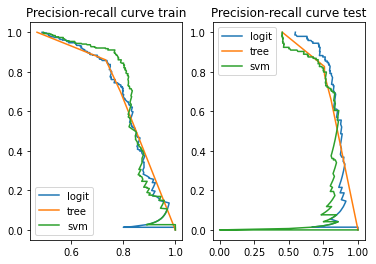

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2)

for model_name in model_map.keys():
  fpr, tpr, thr = metrics.precision_recall_curve(ytrain, xtrain[model_name])
  ax1.plot(fpr, tpr, label=(model_name))
  ax1.legend(loc='best')
  ax1.set_title('Precision-recall curve train')

for model_name in model_map.keys():
  fpr, tpr, thr = metrics.precision_recall_curve(ytest, xtest[model_name])
  ax2.plot(fpr, tpr, label=(model_name))
  ax2.legend(loc='best')
  ax2.set_title('Precision-recall curve test')

We can see that in training set, the model that performed best was the decision tree followed by svm, however in the test the logit seemed to perform better. The argument for this is because the model furthest to the right represents a situation approaching the ideal: high precision and high recall.

In [28]:
normalizado['target_label'] = normalizado['Severity'].apply(lambda x: 'benign' if x == 0 else 'malign')

normalizado_label_map = normalizado[['Severity', 'target_label']].drop_duplicates()

normalizado.drop(columns = 'target_label')

,Age,Shape,Margin,Density,train_set,Severity,logit_prob,tree_prob,svm_prob
944,1.004809,-1.415052,0.781768,0.224804,1,1,0.552964,0.593635,0.794339
216,0.242786,-0.597334,0.781768,0.224804,1,0,0.549605,0.593635,0.383440
750,0.589160,-1.415052,-1.183216,0.224804,1,0,0.197777,0.161919,0.210027
274,0.104237,1.038102,0.781768,0.224804,1,1,0.743707,0.809915,0.735631
687,0.589160,1.038102,0.781768,0.224804,1,1,0.798673,0.809915,0.736221
...,...,...,...,...,...,...,...,...,...
953,0.034962,-0.597334,0.781768,0.224804,0,0,0.516260,0.593635,0.248658
874,0.450610,0.220384,0.126773,0.224804,0,0,0.589667,0.161919,0.237633
168,-0.103588,0.220384,1.436762,0.224804,0,1,0.711322,0.593635,0.753357
515,-2.389656,-1.415052,-1.183216,0.224804,0,0,0.034855,0.161919,0.186970


In [29]:
normalizado_train = normalizado[normalizado['train_set']==1]
normalizado_test = normalizado[normalizado['train_set']==0]

normalizado_train.drop(columns = 'train_set',axis =1, inplace = True)
normalizado_test.drop(columns = 'train_set',axis =1, inplace = True)

normalizado_train_label_map = normalizado_train[['Severity', 'target_label']].drop_duplicates()

normalizado_train.drop(columns = 'target_label')

normalizado_test_label_map = normalizado_test[['Severity', 'target_label']].drop_duplicates()

normalizado_test.drop(columns = 'target_label')

,Age,Shape,Margin,Density,Severity,logit_prob,tree_prob,svm_prob
794,-0.657786,-1.415052,-1.183216,0.224804,0,0.099364,0.161919,0.193661
143,-0.588511,-1.415052,-1.183216,-2.509838,0,0.087868,0.161919,0.079999
480,-1.073435,1.038102,0.126773,0.224804,1,0.464470,0.809915,0.704355
928,1.281908,1.038102,0.126773,0.224804,1,0.798417,0.809915,0.746338
32,0.104237,1.038102,0.781768,0.224804,1,0.743707,0.809915,0.735631
...,...,...,...,...,...,...,...,...
953,0.034962,-0.597334,0.781768,0.224804,0,0.516260,0.593635,0.248658
874,0.450610,0.220384,0.126773,0.224804,0,0.589667,0.161919,0.237633
168,-0.103588,0.220384,1.436762,0.224804,1,0.711322,0.593635,0.753357
515,-2.389656,-1.415052,-1.183216,0.224804,0,0.034855,0.161919,0.186970


Looking at the recall precision curve, we can use an interactive graph to generate the confusion matrix corresponding to each thershold and thus make your choice, being able to observe the final metrics. We will do it for the training and test cases. The following function is an interative function, so feel free to try it yourself in your personal notebook and play with thresholds! 

In [35]:
def plot_operation_threshold(threshold, model_name):
    plt.figure(figsize=(12,4))
    # confusion matrix
    plt.subplot(1,2,1)
    cm = metrics.confusion_matrix(normalizado_train[target_cols],
                                  normalizado_train[model_name + '_prob'] > threshold)
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.title('Confusion matrix ' + model_name + ' training set')
    plt.xlabel('Classification')
    plt.ylabel('Truth')
    plt.gca().set_xticklabels(normalizado_train_label_map.Severity.values)
    plt.gca().set_yticklabels(normalizado_train_label_map.Severity.values)
    # DISTRIBUICAO PROBABILIDADES
    plt.subplot(1,2,2)
    for i in normalizado_train.Severity.unique():
        sns.distplot(normalizado_train[normalizado_train['Severity'] == i][model_name + '_prob'],
                 label=normalizado_train[normalizado_train.Severity == i].Severity,
                 ax = plt.gca())
    plt.plot([threshold, threshold], [0, plt.axis()[3]], '--k', lw=2,
             label = 'Threshold')
    plt.title('Prob distribuition per class ' + model_name + ' treino')
    plt.ylabel('Estimated density')
    plt.xlabel('Prob benign')
    plt.xlim((-0.01,1.01))
    plt.grid()
    plt.legend()
    plt.show()
    # PRINT CLASSIFICATION REPORT
    print(metrics.classification_report(normalizado_train[target_cols],
                                        normalizado_train[model_name + '_prob'] > threshold,
                                        target_names =
                                        normalizado_train_label_map.target_label))
interact(plot_operation_threshold, threshold=(0,1,0.1),
         model_name = ['logit','tree','svm'],
         )

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0), Dropdown(description='model_na…

<function __main__.plot_operation_threshold(threshold, model_name)>

The classes are well balanced, but we can see that at thresholds with higher recall, the accuracy decreases for all models. I set the logit threshold at $40\%$ and got an accuracy of $78\%$, with an f1 of $76\%$, however at this point, a good amount of recall is already 'sacrificed' - which is not a positive thing, the recall here is $68\%$.

As for the tree, at the same threshold we obtain an accuracy of $79\%$ and f1 of $79\%$ with a recall of $86\%$, which does not change so much for the case of a threshold of $50\%$, since in this case the values are in precision $86\%$ and f1 of $85\%$. It's important to perform well on our accuracy metric, but without sacrificing a large percentage of recall, which was not the case above.

In svm, at the threshold of $40\%$ I get an accuracy of $83%$ and f1 of $82\%$, with a recall of $84\%$. I prioritized the thresholds at 0.4 to get a better performance in terms of accuracy, but without compromising the fact that the classes might be a little (just a little, right?) unbalanced. Remembering that these were the performances found for training. In the training case, the best models were in fact the tree and the svm. Let's see now if these generalize well for the test

In [36]:
def plot_operation_threshold(threshold, model_name):
    plt.figure(figsize=(12,4))
    # MATRIZ CONFUSAO
    plt.subplot(1,2,1)
    cm = metrics.confusion_matrix(normalizado_test[target_cols],
                                  normalizado_test[model_name + '_prob'] > threshold)
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.title('Confusion matrix ' + model_name + ' test set')
    plt.xlabel('Classification')
    plt.ylabel('Truth')
    plt.gca().set_xticklabels(normalizado_test_label_map.Severity.values)
    plt.gca().set_yticklabels(normalizado_test_label_map.Severity.values)
    # DISTRIBUICAO PROBABILIDADES
    plt.subplot(1,2,2)
    for i in normalizado_test.Severity.unique():
      sns.distplot(normalizado_test[normalizado_test['Severity'] == i][model_name + '_prob'],
                 label=normalizado_test[normalizado_test.Severity == i].Severity,
                 ax = plt.gca())
    plt.plot([threshold, threshold], [0, plt.axis()[3]], '--k', lw=2,
             label = 'threshold')
    plt.title('Prob distribrution per class ' + model_name + ' test set')
    plt.ylabel('Estimated density')
    plt.xlabel('Prob benign')
    plt.xlim((-0.01,1.01))
    plt.grid()
    plt.legend()
    plt.show()
    # PRINT CLASSIFICATION REPORT
    print(metrics.classification_report(normalizado_test[target_cols],
                                        normalizado_test[model_name + '_prob'] > threshold,
                                        target_names =
                                        normalizado_test_label_map.target_label))
interact(plot_operation_threshold, threshold=(0,1,0.1),
         model_name = ['logit','tree','svm'],
         )

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0), Dropdown(description='model_na…

<function __main__.plot_operation_threshold(threshold, model_name)>

Since I chose threshold at $40\%$, we can see that for logit we got $91\%$ recall, tree $83\%$, and svm $76\%$! This shows us the difference between the performance in training set and test set.

As discussed earlier, a classifier may perform better on the training set, but it does not generalize as well to the test set. In this case, the chosen model that best performed according to precision and f1 in the test is the logistic regression model

## Model explainability

Some models, for example those that assume a linear relationship between the variables, have greater interpretability in relation to their coefficients, while other more complex models, such as svm, have more difficult interpretability. I will now show some aspects that influenced the choice and performance of models.

I used yellowbrick to visualize the importance of attributes, where the relative magnitude scale of coefficient can go from -100 to +100. This allows us to have greater interpretability in terms of comparing their importance. We can see below that Margin is the attribute with the highest relative magnitude of coefficient, that is, we can consider that this is the attribute that most contributes to the model's predictions. Density, on the other hand, does not contribute much to the detection of the severity of the nodules because it has a much smaller relative magnitude than age, shape and margin.

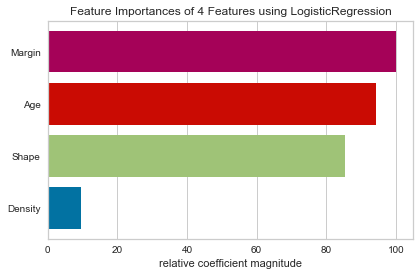

<AxesSubplot:title={'center':'Feature Importances of 4 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [37]:
from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(trained_models['logit'].best_estimator_)
fi_viz.fit(X,Y)
fi_viz.poof()

For the tree, we can perform the same procedure with the coefficients, however the results are different from the logistic regression. Here, the relative importance of the coefficients (gini, as you will see more clearly in the tree path with graphviz) is observed, and it can be seen that the margin attribute has a relative importance that contributes much more to the performance of this model than the other attributes

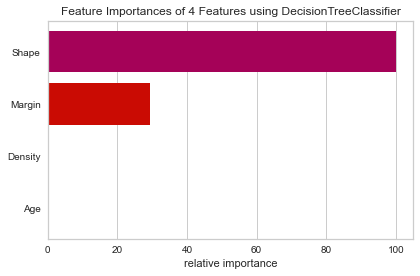

<AxesSubplot:title={'center':'Feature Importances of 4 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [39]:
fig, ax = plt.subplots(figsize=(6,4))

fi_viz_tree = FeatureImportances(trained_models['tree'].best_estimator_)
fi_viz_tree.fit(X,Y)
fi_viz_tree.poof()

In [43]:
xtest.drop(columns = ['logit','tree','svm'], axis =1 , inplace = True)

It is also possible to evaluate, even for the tree, the importance of the variables by entropy and by the permutation procedure, and understand their respective differences between them

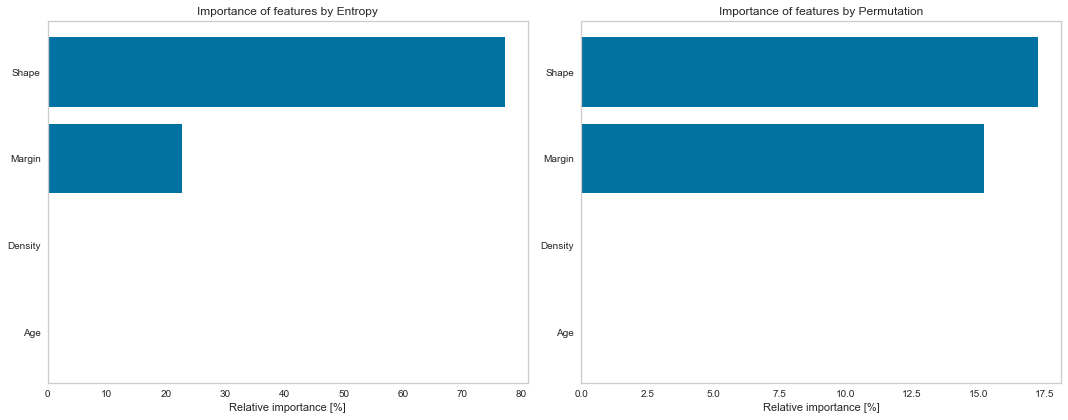

In [44]:
plt.figure(figsize=(15,6))


plt.subplot(1,2,1)
idx = np.argsort(trained_models['tree'].best_estimator_.feature_importances_)

plt.barh(np.arange(idx.shape[0]), trained_models['tree'].best_estimator_.feature_importances_[idx]*100)

plt.yticks(np.arange(idx.shape[0]), np.array(categorical_cols)[idx])
plt.title('Importance of features by Entropy')
plt.grid()
plt.xlabel('Relative importance [%]')
plt.tight_layout()


plt.subplot(1,2,2)
r = permutation_importance(trained_models['tree'].best_estimator_, xtest, ytest,
                           n_repeats=30,
                        random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(categorical_cols)[idx])
plt.title('Importance of features by Permutation')
plt.grid()
plt.xlabel('Relative importance [%]')
plt.tight_layout()

We can see that despite being similar histograms, the values of relative importance for each feature differ from each other

As for svm, we have a model that is not well interpretable. We could use .coefs_ if we were on a linear kernel, but this was not the case for .best_estimator_. In this case, I will use the SHAP library, which shows the importance of attributes for any model. Here he summarizes all attributes, showing the global impact but also the individual impacts. The most important attributes can be seen at the top

In [45]:
sv = trained_models['svm'].best_estimator_

sv.fit(xtrain[categorical_cols],ytrain)

SVC(C=100, class_weight='balanced', probability=True)

In [47]:
rf_shap_values = shap.KernelExplainer(sv.predict,xtest[categorical_cols])

Using 318 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [48]:
rf_shap_values

In [49]:
svm_explainer = shap.KernelExplainer(sv.predict, xtest[categorical_cols])
svm_shap_values = svm_explainer.shap_values(xtest[categorical_cols])

Using 318 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/318 [00:00<?, ?it/s]

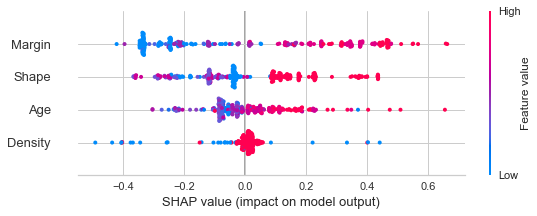

In [50]:
shap.summary_plot(svm_shap_values, xtest[categorical_cols])

Attributes are given certain colors according to their values. A high margin score will push the model to classify a nodule as malignant. Density is found here as the attribute that contributes the least to the svm model